## Treść zadania

Zbudować autoenkoder wykorzystując zbiór CIFAR10

1. Podzielić zbiór na ciąg trenujący i uczący w proporcjach: 50000, 10000
2. Zwizualizować 10-25 przykładów ze zbioru
3. Wytrenować autoenkoder w wykorzystaniem **warstw  Dense**
    - warstwa kodująca powinna składać się z 512 neuronów.
    - baseline: dwie wartswy gęste + kodująca (2048,1024, 512 neuronów), funkcje aktywacji ReLU, wyjście z ostatniej warstwy sigmoid.
    - funkcja straty: błąd średniokowadratowy, optimizer SGD
    - liczba epok uczenia: 100, batch_size= 1024
4. Wytrenować autoenkoder w wykorzystaniem **warstw splotowych**
    - warstwa kodująca powinna składać się z nie więcej niż  512 neuronów.
    - funkcja straty: błąd średniokowadratowy, optimizer SGD
    - liczba epok uczenia: 100, batch_size= 1024
5. Skomentować przebieg procesu uczenia na podstawie metryk na zbiorze uczącym i
testowym w kolejnych epokach uczenia (można zwizualizować). Czy nastąpił overfitting / underfitting ?
6. Przedsawienie błędu rekonsturkcji w zależności od rozmiaru wektora "bottlleneck"
7. Zwizualizować 10-25 przykładów  obraz wejściowy - rekonstrukcja
8. Zbudować prosty klasyfikator wykorzystujący:
    - warstwę enkodującą do transformacji wejścia do wektora o rozmiarze 512 (ta warstwa nie będzie zmieniana podczas uczenia)
    - dwie warstwy gęste: ostatnia z funkcją aktywacji softmax
    - optimizer SGD, funkcja straty: CategoricalCrossentropy
9. Zbadać metrykę accuracy na zbiorze testowym  (ile obrazów zostało poprawnie zaklasyfikowanych)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [72]:
CLASS_NAMES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
NUM_CLASSES = len(CLASS_NAMES)
NUM_EXAMPLES = 25
INPUT_SHAPE = (32, 32, 3)

## Funkcje pomocnicze

In [33]:
def visualize_examples(data, labels, title="CIFAR10 Examples"):
    """Visualizes a few examples from the dataset."""
    plt.figure(figsize=(10, 10))
    for i in range(NUM_EXAMPLES):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(data[i])
        plt.title(CLASS_NAMES[labels[i][0]])
        plt.axis("off")
    plt.show()

In [22]:
def plot_training_history(history, model_name="Model"):
    """Plots the training and validation loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{model_name} - Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [46]:
def compile_and_train_model(
    model,
    x_train,
    x_test,
    epochs=100,
    batch_size=1024,
    loss="mean_squared_error",
    optimizer_name="sgd",
):
    """Compiles and trains a given model."""
    if optimizer_name.lower() == "sgd":
        optimizer = keras.optimizers.SGD()
    elif optimizer_name.lower() == "adam":
        optimizer = keras.optimizers.Adam()
    else:
        optimizer = optimizer_name

    model.compile(optimizer=optimizer, loss=loss)
    history = model.fit(
        x_train,
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test, x_test),
    )
    return history

In [44]:
def build_dense_autoencoder(input_shape=INPUT_SHAPE, encoding_dim=512):
    """Builds a dense autoencoder model."""
    # Encoder Model
    encoder = models.Sequential(
        [
            layers.Flatten(input_shape=input_shape),
            layers.Dense(2048, activation="relu"),
            layers.Dense(1024, activation="relu"),
            layers.Dense(encoding_dim, activation="sigmoid"),
        ],
        name="dense_encoder",
    )

    # Decoder Model
    decoder = models.Sequential(
        [
            layers.Dense(1024, activation="relu", input_shape=(encoding_dim,)),
            layers.Dense(2048, activation="relu"),
            layers.Dense(32 * 32 * 3, activation="sigmoid"),
            layers.Reshape((32, 32, 3)),
        ],
        name="dense_decoder",
    )

    # Autoencoder Model (Encoder + Decoder)
    autoencoder = models.Sequential([encoder, decoder], name="dense_autoencoder")
    return encoder, decoder, autoencoder

In [45]:
def build_conv_autoencoder(input_shape=INPUT_SHAPE, encoding_dim=256):
    """Builds a convolutional autoencoder model"""
    shape_before_flatten = (4, 4, 128)
    num_neurons_for_reshape = (
        shape_before_flatten[0] * shape_before_flatten[1] * shape_before_flatten[2]
    )

    # Encoder Model
    encoder = models.Sequential(
        [
            layers.Conv2D(
                32, (3, 3), activation="relu", padding="same", input_shape=input_shape
            ),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Flatten(),
            layers.Dense(encoding_dim, activation="relu", name="encoder_output"),
        ],
        name="convolutional_encoder",
    )

    # Decoder Model
    decoder = models.Sequential(
        [
            layers.Dense(
                num_neurons_for_reshape, activation="relu", input_shape=(encoding_dim,)
            ),
            layers.Reshape(shape_before_flatten),
            layers.Conv2DTranspose(
                128, (3, 3), strides=2, activation="relu", padding="same"
            ),
            layers.Conv2DTranspose(
                64, (3, 3), strides=2, activation="relu", padding="same"
            ),
            layers.Conv2DTranspose(
                32, (3, 3), strides=2, activation="relu", padding="same"
            ),
            layers.Conv2D(input_shape[2], (3, 3), activation="sigmoid", padding="same"),
        ],
        name="convolutional_decoder",
    )

    # Autoencoder Model (Encoder + Decoder)
    autoencoder = models.Sequential(
        [encoder, decoder], name="convolutional_autoencoder"
    )

    return encoder, decoder, autoencoder

In [66]:
def build_and_train_classifier(
    encoder_model,
    x_train_orig,
    y_train_orig,
    x_test_orig,
    y_test_orig,
    num_classes=10,
    hidden_layer_neurons=128,
    epochs=50,
    batch_size=1024,
    optimizer_name="sgd",
):
    """Builds and trains a classifier using a pre-trained, frozen encoder."""
    print("\n--- Building and Training Classifier with Pre-trained Encoder ---")

    # 1. One-hot encode labels
    y_train_cat = keras.utils.to_categorical(y_train_orig, num_classes)
    y_test_cat = keras.utils.to_categorical(y_test_orig, num_classes)

    # 2. Freeze the encoder model's layers
    encoder_model.trainable = False
    print("Encoder model summary (frozen for classification):")
    encoder_model.summary()

    # 3. Define the classifier model
    model_input = encoder_model.input  # Get input from the encoder
    encoded_features = encoder_model.output  # Get output of the encoder

    x = layers.Dense(hidden_layer_neurons, activation="relu")(encoded_features)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)

    classifier = keras.Model(
        inputs=model_input, outputs=output_layer, name="classifier"
    )

    print("Classifier model summary:")
    classifier.summary()

    # 4. Compile the classifier
    if optimizer_name.lower() == "sgd":
        optimizer = keras.optimizers.SGD()
    elif optimizer_name.lower() == "adam":
        optimizer = keras.optimizers.Adam()
    else:
        optimizer = optimizer_name
    classifier.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # 5. Train the classifier
    print("\nTraining the classifier...")
    history = classifier.fit(
        x_train_orig,
        y_train_cat,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test_orig, y_test_cat),
    )

    # 6. Plot training history (loss and accuracy)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Classifier Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Crossentropy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Classifier Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 7. Evaluate on test set
    loss, accuracy = classifier.evaluate(x_test_orig, y_test_cat, verbose=0)
    print(f"\nClassifier Test Accuracy: {accuracy*100:.2f}%")
    print(f"Classifier Test Loss: {loss:.4f}")

    return classifier, history

In [78]:
def evaluate_bottleneck_effect(
    model_builder,
    x_train,
    x_test,
    input_shape_or_dim,
    bottleneck_sizes,
    model_type="Dense",
    epochs=25,
    batch_size=1024,
):
    """Trains autoencoders with different bottleneck sizes and plots reconstruction error."""
    test_mses = []

    print(f"\n--- Evaluating Bottleneck Effect for {model_type} Autoencoder ---")
    print(f"Bottleneck sizes to test: {bottleneck_sizes}")

    for size in bottleneck_sizes:
        print(f"\nTraining {model_type} autoencoder with bottleneck size: {size}")
        _, _, autoencoder = model_builder(
            input_shape=input_shape_or_dim, encoding_dim=size
        )

        history = compile_and_train_model(
            autoencoder,
            x_train,
            x_test,
            epochs=epochs,
            batch_size=batch_size,
            loss="mean_squared_error",
            optimizer_name="adam",
        )

        # Get the final validation loss as the reconstruction error
        final_val_mse = history.history["val_loss"][-1]
        test_mses.append(final_val_mse)
        print(
            f"{model_type} Autoencoder (bottleneck {size}) - Final Test MSE: {final_val_mse:.6f}"
        )

    plt.figure(figsize=(10, 5))
    plt.plot(bottleneck_sizes, test_mses, marker="o")
    plt.title(f"{model_type} Autoencoder - Reconstruction MSE vs. Bottleneck Size")
    plt.xlabel("Bottleneck Size (Number of Neurons)")
    plt.ylabel("Test Reconstruction MSE")
    plt.xticks(bottleneck_sizes)
    plt.grid(True)
    plt.show()
    return test_mses

## Zbiór danych

In [14]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
assert train_images.shape == (50000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)
assert train_labels.shape == (50000, 1)
assert test_labels.shape == (10000, 1)
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

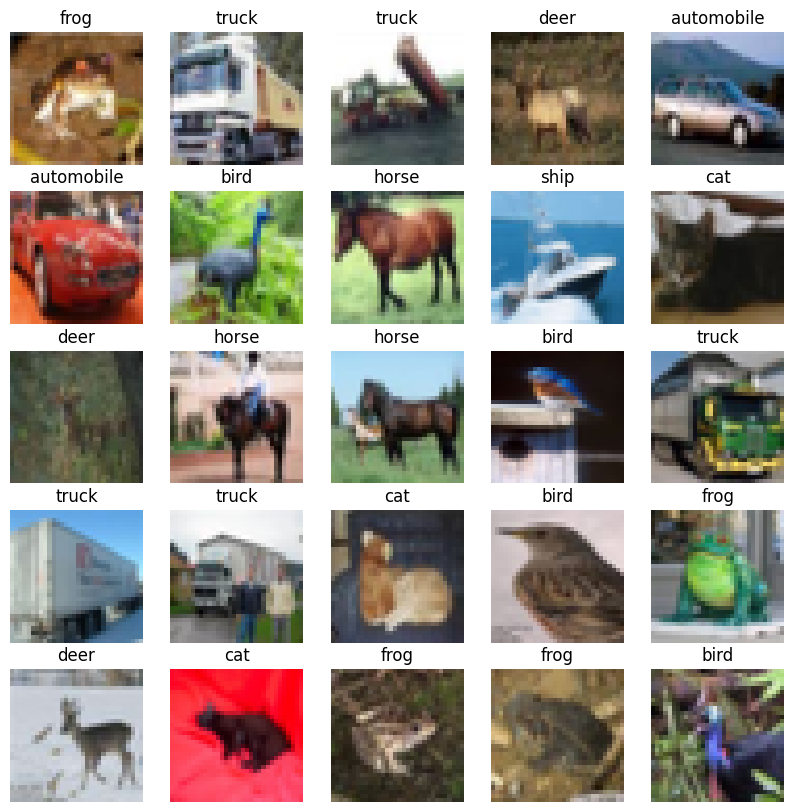

In [15]:
# Visualize the first 25 images in the training set
visualize_examples(train_images, train_labels)

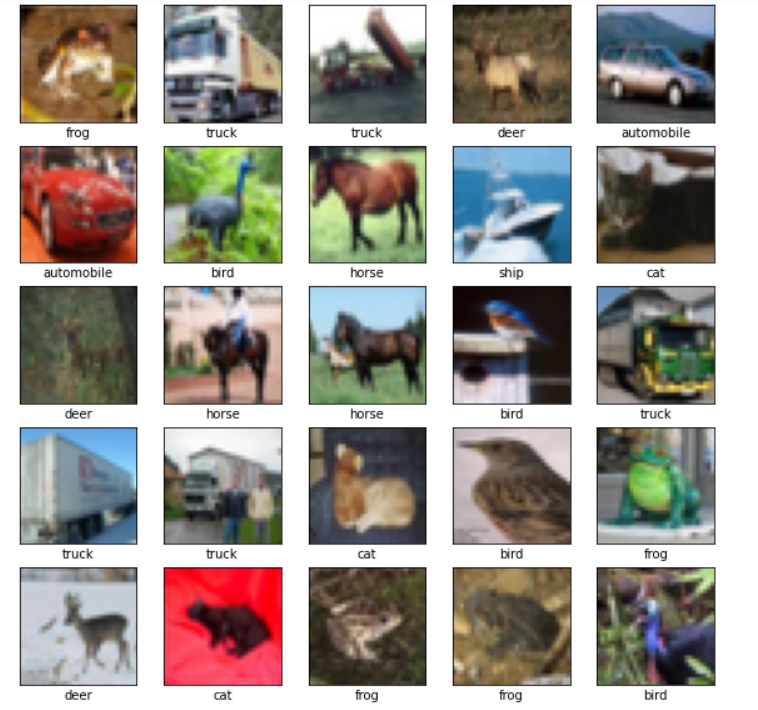

## Model autoencodera (dense)

In [49]:
dense_encoder, dense_decoder, dense_autoencoder = build_dense_autoencoder(
    input_shape=INPUT_SHAPE
)
print(dense_encoder.summary())
print(dense_decoder.summary())
print(dense_autoencoder.summary())

Model: "dense_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 512)            │       524,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,916,480 (34.01 MB)

 Trainable params: 8,916,480 (34.01 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "dense_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3072)           │     6,294,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,919,040 (34.02 MB)

 Trainable params: 8,919,040 (34.02 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "dense_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_encoder (Sequential)      │ (None, 512)            │     8,916,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_decoder (Sequential)      │ (None, 32, 32, 3)      │     8,919,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,835,520 (68.04 MB)

 Trainable params: 17,835,520 (68.04 MB)

 Non-trainable params: 0 (0.00 B)

None


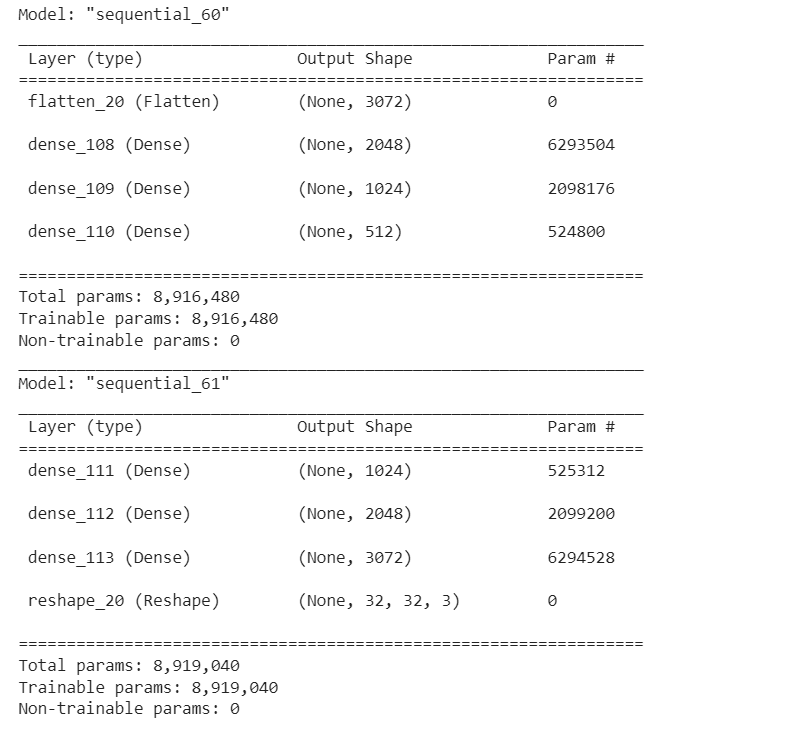

In [50]:
# Training the autoencoder (sgd)
dense_history = compile_and_train_model(
    dense_autoencoder,
    train_images,
    test_images,
    epochs=100,
    batch_size=1024,
    loss="mean_squared_error",
    optimizer_name="sgd",
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0653 - val_loss: 0.0649
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0652 - val_loss: 0.0649
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0652 - val_loss: 0.0649
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0651 - val_loss: 0.0648
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0653 - val_loss: 0.0648
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0652 - val_loss: 0.0648
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0653 - val_loss: 0.0648
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0649 - val_loss: 0.0647
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0651 - val_loss: 0.0647
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0652 - val_loss: 0.0647
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0650 - val_loss: 0.0647
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step

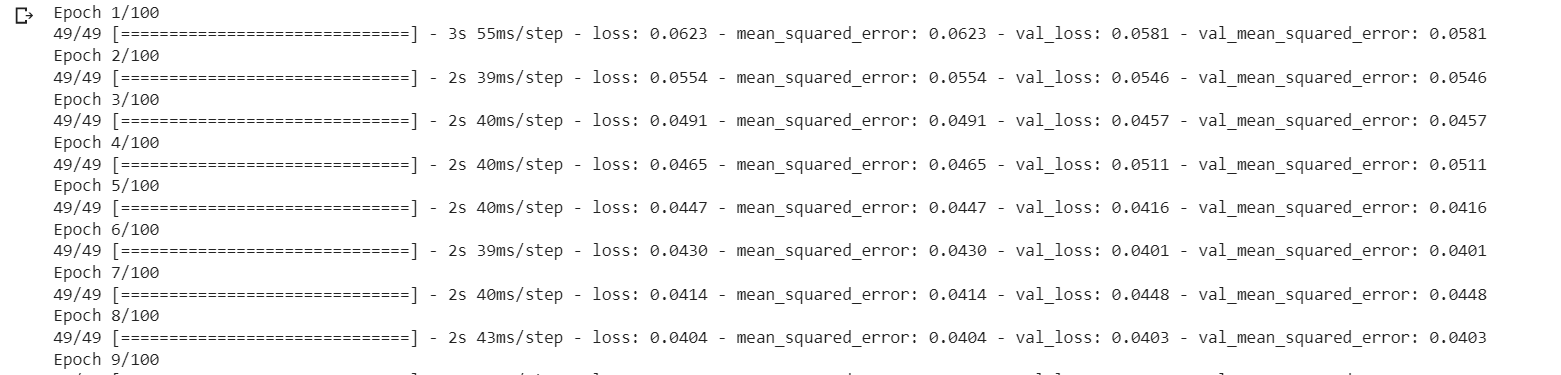

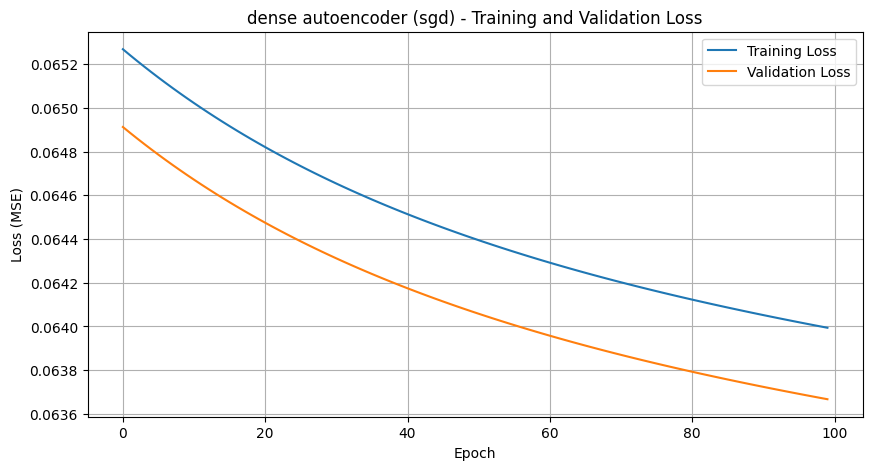

In [51]:
plot_training_history(dense_history, "dense autoencoder (sgd)")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


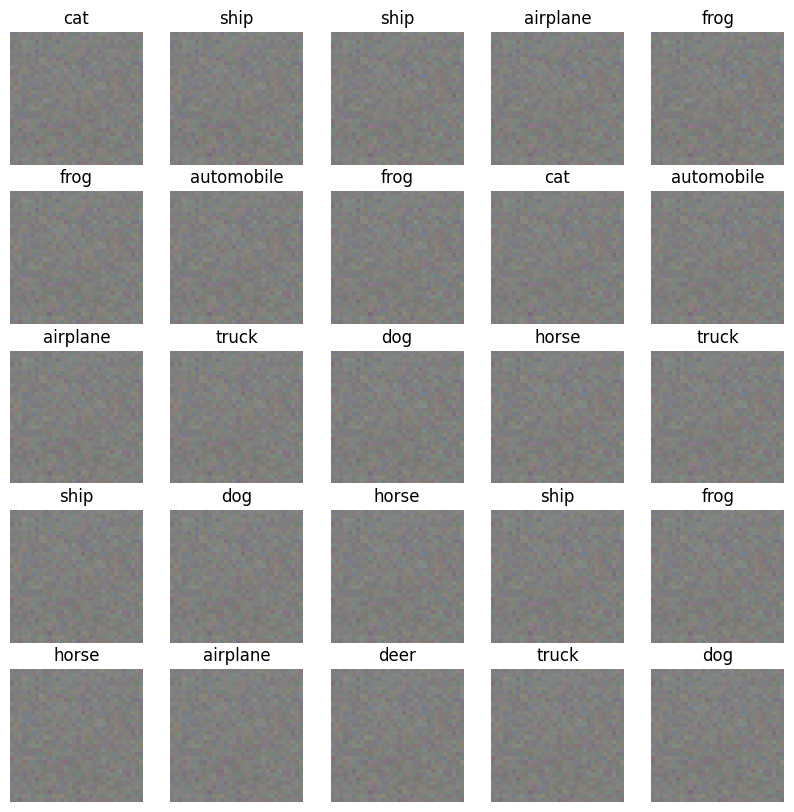

In [52]:
# Reconstruct images using the dense autoencoder (sgd)
reconstructed_imgs = dense_autoencoder.predict(test_images)
visualize_examples(reconstructed_imgs, test_labels)

In [54]:
# Training the autoencoder (adam)
dense_encoder_adam, dense_decoder_adam, dense_autoencoder_adam = (
    build_dense_autoencoder(input_shape=INPUT_SHAPE)
)
dense_history_adam = compile_and_train_model(
    dense_autoencoder_adam,
    train_images,
    test_images,
    epochs=100,
    batch_size=1024,
    loss="mean_squared_error",
    optimizer_name="adam",
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0575 - val_loss: 0.0391
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0385 - val_loss: 0.0363
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0348 - val_loss: 0.0326
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0325 - val_loss: 0.0310
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0306 - val_loss: 0.0302
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0297 - val_loss: 0.0267
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0264 - val_loss: 0.0258
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0252 - val_loss: 0.0245
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0245 - val_loss: 0.0236
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0236 - val_loss: 0.0251
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0240 - val_loss: 0.0234
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step

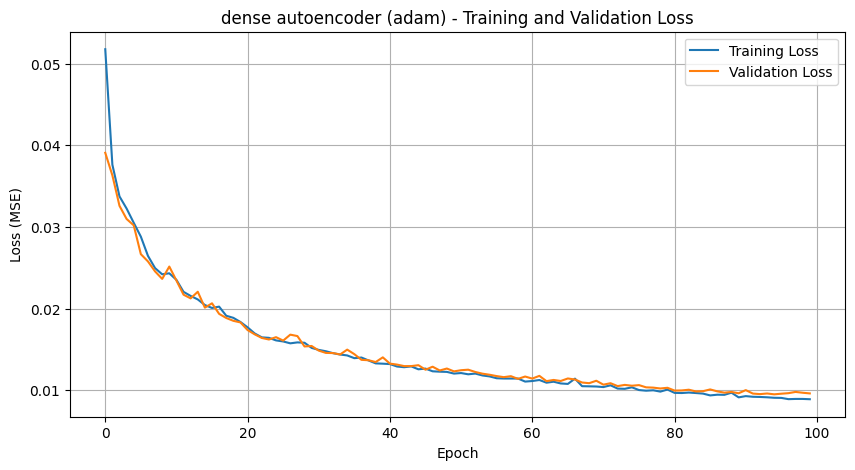

In [55]:
plot_training_history(dense_history_adam, "dense autoencoder (adam)")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


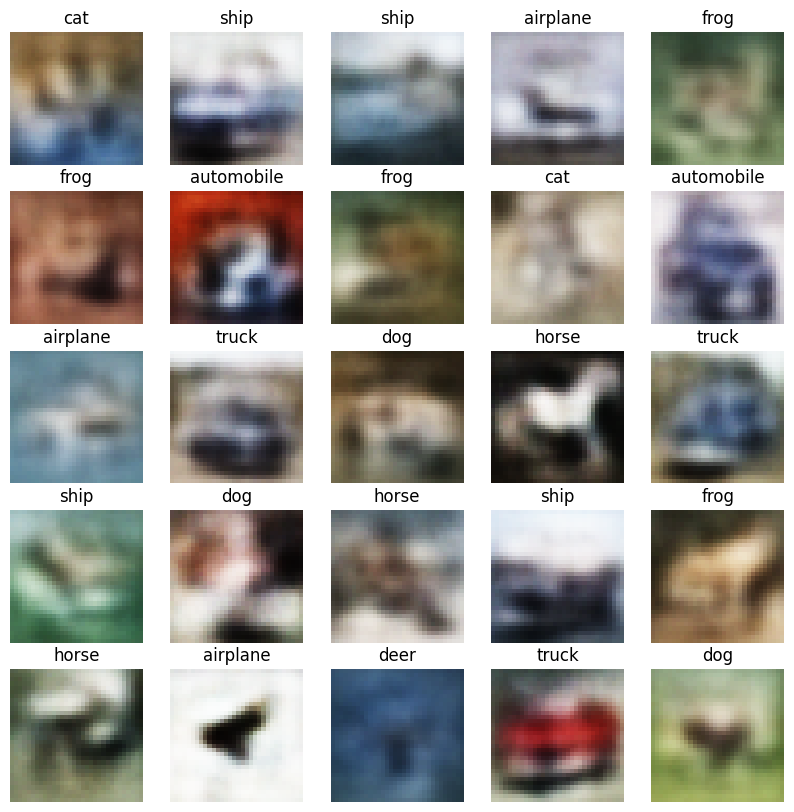

In [56]:
reconstructed_imgs_adam = dense_autoencoder_adam.predict(test_images)
visualize_examples(reconstructed_imgs_adam, test_labels)

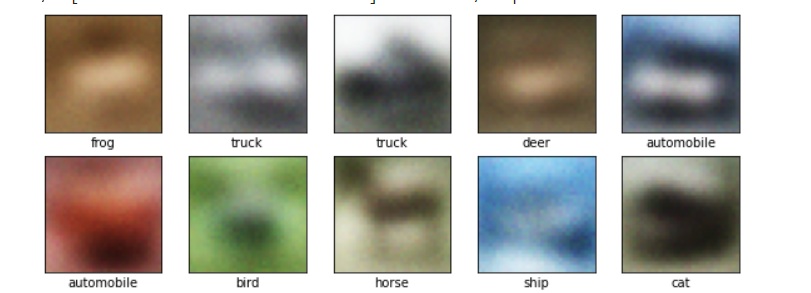


--- Building and Training Classifier with Pre-trained Encoder ---
Encoder model summary (frozen for classification):


Model: "dense_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │       524,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,916,480 (34.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,916,480 (34.01 MB)

Classifier model summary:


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_encoder (Sequential)      │ (None, 512)            │     8,916,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,983,434 (34.27 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 8,916,480 (34.01 MB)


Training the classifier...
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.0949 - loss: 2.3275 - val_accuracy: 0.1351 - val_loss: 2.2719
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1447 - loss: 2.2673 - val_accuracy: 0.1799 - val_loss: 2.2424
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1846 - loss: 2.2400 - val_accuracy: 0.2093 - val_loss: 2.2171
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2164 - loss: 2.2135 - val_accuracy: 0.2300 - val_loss: 2.1943
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2302 - loss: 2.1913 - val_accuracy: 0.2481 - val_loss: 2.1728
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2505 - loss: 2.1696 - val_accuracy: 0.2622 - val_loss: 2.1528
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2635 - loss: 2.1486 - val_accuracy: 0.2727 - val_loss: 2.1338
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2748 - loss: 2.131

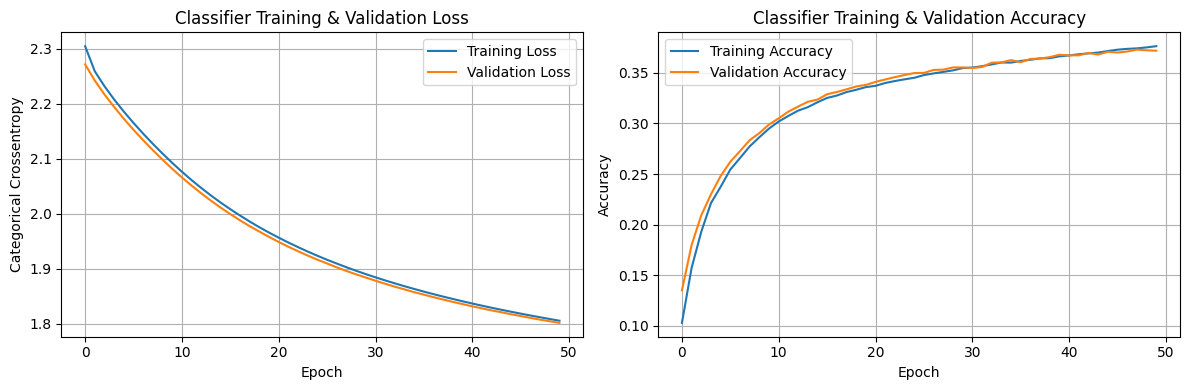


Classifier Test Accuracy: 37.19%
Classifier Test Loss: 1.8013


(<Functional name=classifier, built=True>,
 <keras.src.callbacks.history.History at 0x7e7bb7a19790>)

In [67]:
# classifier (sgd)
build_and_train_classifier(
    encoder_model=dense_encoder_adam,
    x_train_orig=train_images,
    y_train_orig=train_labels,
    x_test_orig=test_images,
    y_test_orig=test_labels,
    num_classes=NUM_CLASSES,
    epochs=50,
    optimizer_name="sgd",
)


--- Building and Training Classifier with Pre-trained Encoder ---
Encoder model summary (frozen for classification):


Model: "dense_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │       524,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,916,480 (34.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,916,480 (34.01 MB)

Classifier model summary:


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_encoder (Sequential)      │ (None, 512)            │     8,916,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,983,434 (34.27 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 8,916,480 (34.01 MB)


Training the classifier...
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.2229 - loss: 2.1633 - val_accuracy: 0.3608 - val_loss: 1.8588
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3683 - loss: 1.8241 - val_accuracy: 0.3913 - val_loss: 1.7490
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3934 - loss: 1.7340 - val_accuracy: 0.4092 - val_loss: 1.6978
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4097 - loss: 1.6968 - val_accuracy: 0.4185 - val_loss: 1.6607
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4201 - loss: 1.6540 - val_accuracy: 0.4193 - val_loss: 1.6408
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4279 - loss: 1.6277 - val_accuracy: 0.4324 - val_loss: 1.6181
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4307 - loss: 1.6137 - val_accuracy: 0.4345 - val_loss: 1.6025
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4391 - loss: 1.593

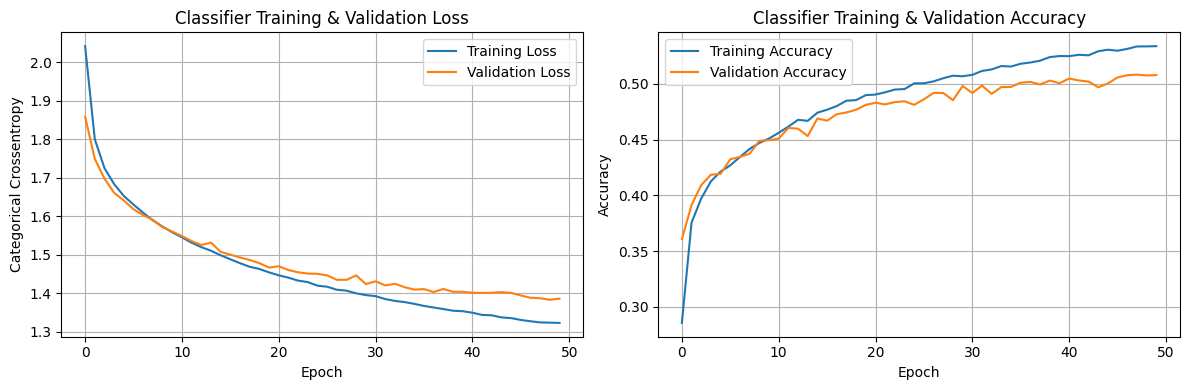


Classifier Test Accuracy: 50.79%
Classifier Test Loss: 1.3857


(<Functional name=classifier, built=True>,
 <keras.src.callbacks.history.History at 0x7e7bb7f8b650>)

In [68]:
# classifier (adam)
build_and_train_classifier(
    encoder_model=dense_encoder_adam,
    x_train_orig=train_images,
    y_train_orig=train_labels,
    x_test_orig=test_images,
    y_test_orig=test_labels,
    num_classes=NUM_CLASSES,
    epochs=50,
    optimizer_name="adam",
)

## Model autodencodera (conv)

In [57]:
conv_encoder, conv_decoder, conv_autoencoder = build_conv_autoencoder(
    input_shape=INPUT_SHAPE, encoding_dim=256
)
print(conv_encoder.summary())
print(conv_decoder.summary())
print(conv_autoencoder.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "convolutional_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 256)            │       524,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,792 (2.36 MB)

 Trainable params: 617,792 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "convolutional_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 2048)           │       526,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 767,043 (2.93 MB)

 Trainable params: 767,043 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "convolutional_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convolutional_encoder           │ (None, 256)            │       617,792 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolutional_decoder           │ (None, 32, 32, 3)      │       767,043 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,384,835 (5.28 MB)

 Trainable params: 1,384,835 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [59]:
conv_history = compile_and_train_model(
    conv_autoencoder,
    train_images,
    test_images,
    epochs=100,
    batch_size=1024,
    loss="mean_squared_error",
    optimizer_name="adam",
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - loss: 0.0617 - val_loss: 0.0394
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0350 - val_loss: 0.0257
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0251 - val_loss: 0.0219
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0211 - val_loss: 0.0195
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0192 - val_loss: 0.0186
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0183 - val_loss: 0.0176
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0173 - val_loss: 0.0182
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.0169 - val_loss: 0.0164
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0156 - val_loss: 0.0139
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0141 - val_loss: 0.0137
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0131 - val_loss: 0.0170
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━

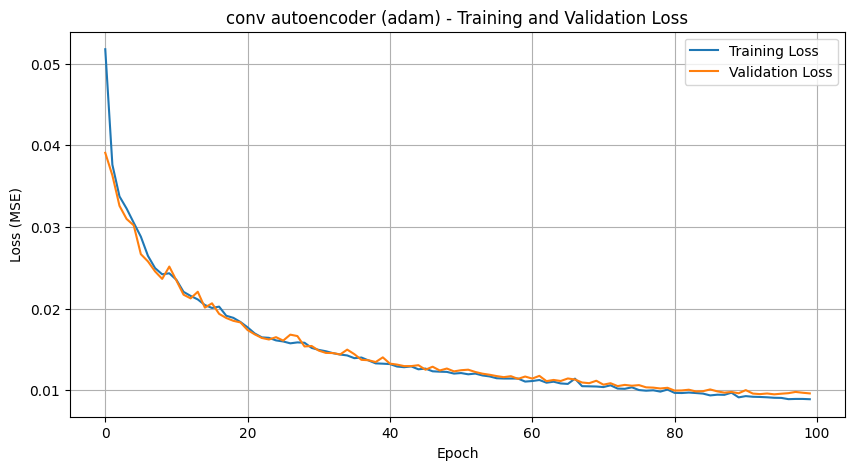

In [61]:
plot_training_history(dense_history_adam, "conv autoencoder (adam)")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


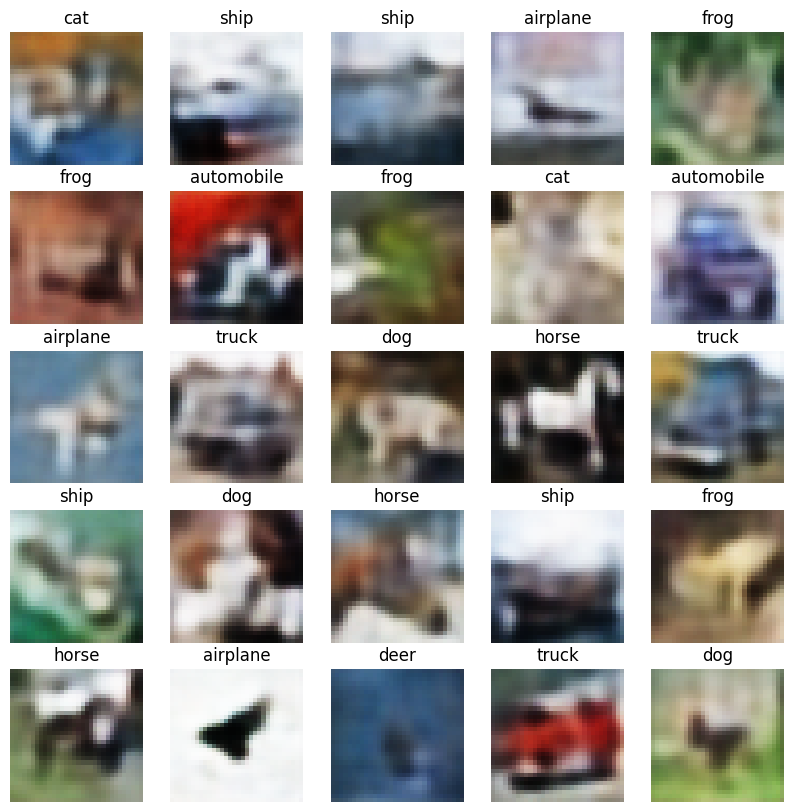

In [62]:
reconstructed_imgs_conv = conv_autoencoder.predict(test_images)
visualize_examples(reconstructed_imgs_conv, test_labels)


--- Building and Training Classifier with Pre-trained Encoder ---
Encoder model summary (frozen for classification):


Model: "convolutional_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 256)            │       524,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,792 (2.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 617,792 (2.36 MB)

Classifier model summary:


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolutional_encoder           │ (None, 256)            │       617,792 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,978 (2.49 MB)

 Trainable params: 34,186 (133.54 KB)

 Non-trainable params: 617,792 (2.36 MB)


Training the classifier...
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.1665 - loss: 2.4169 - val_accuracy: 0.2928 - val_loss: 1.9756
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3142 - loss: 1.9380 - val_accuracy: 0.3526 - val_loss: 1.8390
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3586 - loss: 1.8302 - val_accuracy: 0.3764 - val_loss: 1.7716
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3795 - loss: 1.7666 - val_accuracy: 0.3968 - val_loss: 1.7220
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4041 - loss: 1.7073 - val_accuracy: 0.4044 - val_loss: 1.6840
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4150 - loss: 1.6729 - val_accuracy: 0.4249 - val_loss: 1.6454
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4285 - loss: 1.6384 - val_accuracy: 0.4310 - val_loss: 1.6159
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4396 - loss: 1.611

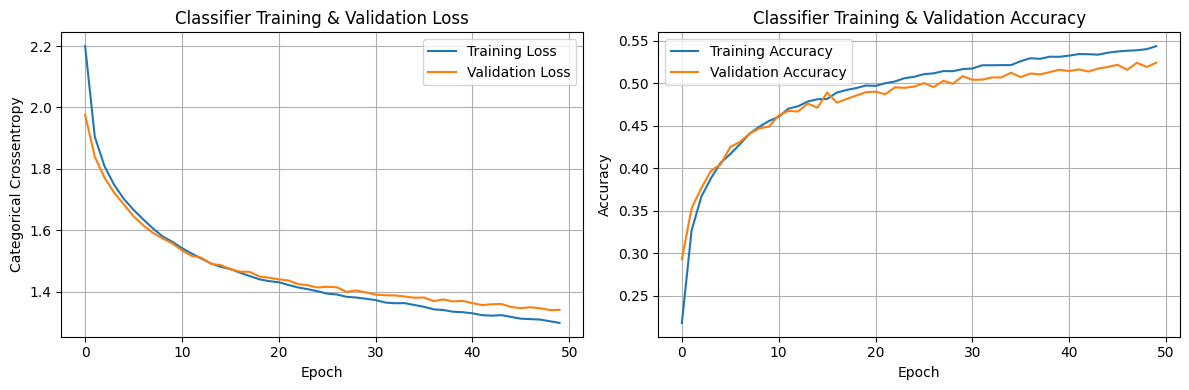


Classifier Test Accuracy: 52.40%
Classifier Test Loss: 1.3403


(<Functional name=classifier, built=True>,
 <keras.src.callbacks.history.History at 0x7e7bbb8a7210>)

In [69]:
# classifier conv
build_and_train_classifier(
    encoder_model=conv_encoder,
    x_train_orig=train_images,
    y_train_orig=train_labels,
    x_test_orig=test_images,
    y_test_orig=test_labels,
    num_classes=NUM_CLASSES,
    epochs=50,
    optimizer_name="adam",
)

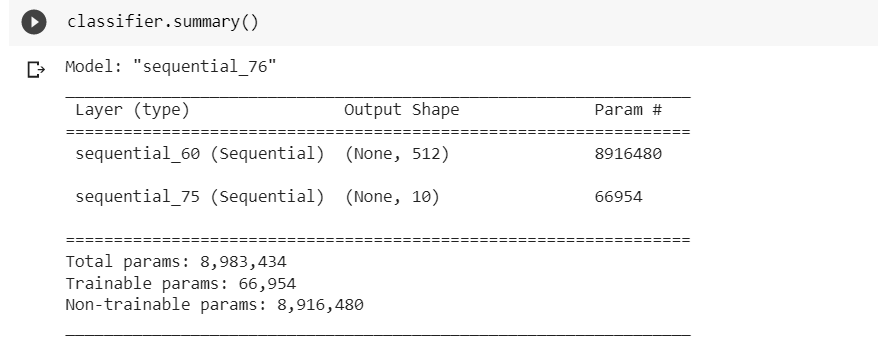

Accuracy na zbiorze testowym:

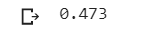

## Evaluate Bottlleneck Effect

In [74]:
bottleneck_sizes_to_test = [64, 128, 256, 512]


--- Evaluating Bottleneck Effect for Dense Autoencoder ---
Bottleneck sizes to test: [64, 128, 256, 512]

Training Dense autoencoder with bottleneck size: 64
Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0580 - val_loss: 0.0427
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0406 - val_loss: 0.0372
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0359 - val_loss: 0.0326
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0322 - val_loss: 0.0308
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0308 - val_loss: 0.0305
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0304 - val_loss: 0.0293
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0294 - val_loss: 0.0286
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0286 - val_loss: 0.0281
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0264 - val_loss: 0.0248
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0248 - val_los

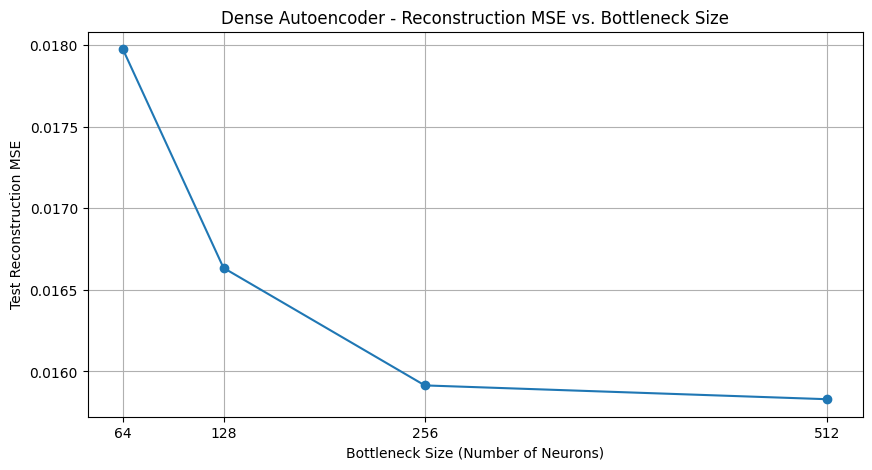

[0.017973989248275757,
 0.01663443259894848,
 0.01591469720005989,
 0.01583007536828518]

In [79]:
# For Dense Autoencoder
evaluate_bottleneck_effect(
    model_builder=build_dense_autoencoder,
    x_train=train_images,
    x_test=test_images,
    input_shape_or_dim=INPUT_SHAPE,
    bottleneck_sizes=bottleneck_sizes_to_test,
    model_type="Dense",
    epochs=25,
)


--- Evaluating Bottleneck Effect for Conv Autoencoder ---
Bottleneck sizes to test: [64, 128, 256, 512]

Training Conv autoencoder with bottleneck size: 64
Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0580 - val_loss: 0.0485
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0434 - val_loss: 0.0372
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0369 - val_loss: 0.0333
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0334 - val_loss: 0.0307
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0307 - val_loss: 0.0305
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0307 - val_loss: 0.0307
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0302 - val_loss: 0.0290
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0289 - val_loss: 0.0269
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0264 - val_loss:

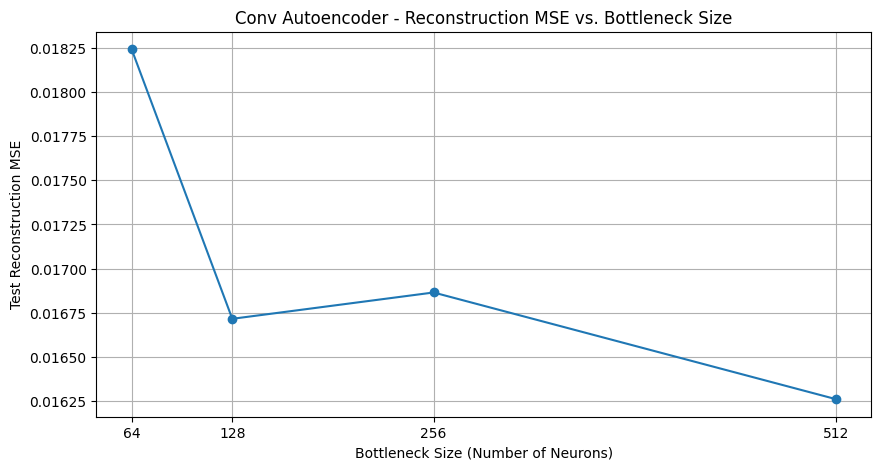

[0.01824110373854637,
 0.01671585999429226,
 0.016864782199263573,
 0.01626087725162506]

In [80]:
# For Conv Autoencoder
evaluate_bottleneck_effect(
    model_builder=build_dense_autoencoder,
    x_train=train_images,
    x_test=test_images,
    input_shape_or_dim=INPUT_SHAPE,
    bottleneck_sizes=bottleneck_sizes_to_test,
    model_type="Conv",
    epochs=25,
)

## Wnioski

1. W ramach eksperymentu zaimplementowałem i wytrenowałem dwa typy autoenkoderów: gęsty oraz splotowy, używając do tego celu zbioru danych CIFAR10.
2. Obserwowałem, że krzywe uczenia i walidacji dla obu autoenkoderów spadały równomiernie, co sugeruje, że modele nie uległy ani przeuczeniu, ani niedouczeniu przy odpowiednio dobranych parametrach.
3. Zauważyłem, że optymalizator SGD nie przynosił dobrych rezultatów, szczególnie w przypadku autoenkodera gęstego, który generował jedynie szum zamiast sensownych rekonstrukcji.
4. Stwierdziłem, że optymalizator Adam sprawdził się znacznie lepiej, prowadząc do stabilnego uczenia i dobrych wyników dla obu testowanych architektur autoenkoderów.
5. Doszedłem do wniosku, że autoenkodery splotowe, mimo potencjalnie mniejszej liczby parametrów, radziły sobie znacznie lepiej niż gęste, zarówno w zadaniu rekonstrukcji obrazu, jak i jako ekstraktory cech dla klasyfikatora.